# Source Code:  Model Building for Mortality in the United States

## Introduction 
This file contains the source code supporting the GLM models that were built during work on the `Mortality in the United States` report created by the following individuals, as a part of Washington University's Foundations of Analytics course. 

* Kunihiro Fujita 
* Qi Lu
* Segun Akinyemi
* Gowtham Anbumani

In [ ]:
import json
import math
import warnings
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


# Prepare for using 'age_recode_12'

In [59]:
unuseful_colnames=[
       'resident_status',
       'education_reporting_flag', 'detail_age_type',
       'detail_age', 'age_substitution_flag', 'age_recode_52','age_recode_27', 'icd_code_10th_revision',
       'infant_age_recode_22',
       'place_of_death_and_decedents_status', 
       'day_of_week_of_death', 
       'method_of_disposition','autopsy', 
       'place_of_injury_for_causes_w00_y34_except_y06_and_y07_',
       '358_cause_recode', 'activity_code',
       '130_infant_cause_recode', '39_cause_recode',
       'number_of_entity_axis_conditions', 'entity_condition_1',
       'entity_condition_2', 'entity_condition_3', 'entity_condition_4',
       'entity_condition_5', 'entity_condition_6', 'entity_condition_7',
       'entity_condition_8', 'entity_condition_9', 'entity_condition_10',
       'entity_condition_11', 'entity_condition_12', 'entity_condition_13',
       'entity_condition_14', 'entity_condition_15', 'entity_condition_16',
       'entity_condition_17', 'entity_condition_18', 'entity_condition_19',
       'entity_condition_20', 'number_of_record_axis_conditions',
       'record_condition_1', 'record_condition_2', 'record_condition_3',
       'record_condition_4', 'record_condition_5', 'record_condition_6',
       'record_condition_7', 'record_condition_8', 'record_condition_9',
       'record_condition_10', 'record_condition_11', 'record_condition_12',
       'record_condition_13', 'record_condition_14', 'record_condition_15',
       'record_condition_16', 'record_condition_17', 'record_condition_18',
       'record_condition_19', 'record_condition_20', 
       'race','bridged_race_flag', 'race_imputation_flag', 'race_recode_3',
       'hispanic_origin', 'hispanic_originrace_recode']

In [36]:
unuseful_colnames2=[
    'education_1989_revision', 'education_2003_revision', 
    'month_of_death', 'sex', 'marital_status', 'current_data_year', 
    'injury_at_work', 'manner_of_death', '113_cause_recode',
    'race_recode_5']

# Import Data from CSV
### 'df.csv' file includes data between 2005 to 2015, which drops all useless colums. Useless columns are shown below. In addition, column of education are converted appropriately. That is, this file includes all necessary variables we chose and their data.

In [2]:
# read df.csv
warnings.filterwarnings('ignore')
df = pd.read_csv( './df.csv', na_values=['NA','?'])
age_recode_12 = pd.read_csv( './age_recode_12.csv', na_values=['NA','?'])

In [3]:
df = pd.concat([df, age_recode_12], axis=1)

In [4]:
df.head(5)

,Unnamed: 0,113_cause_recode,age_recode_27,current_data_year,education_2003_revision,injury_at_work,manner_of_death,marital_status,month_of_death,race_recode_5,sex,Unnamed: 0,age_recode_12
0,0,28,15,2005,2.0,U,7.0,M,1,1,F,0,7
1,1,84,18,2005,4.0,U,7.0,D,1,1,M,1,8
2,2,70,21,2005,3.0,U,7.0,D,1,1,F,2,10
3,3,46,16,2005,3.0,U,7.0,S,1,1,M,3,7
4,4,27,19,2005,4.0,U,7.0,M,1,1,F,4,9


In [4]:
df = df.drop('age_recode_27', axis=1)

In [5]:
df = df.drop('Unnamed: 0', axis=1)

In [7]:
df.head(10)

,113_cause_recode,current_data_year,education_2003_revision,injury_at_work,manner_of_death,marital_status,month_of_death,race_recode_5,sex,age_recode_12
0,28,2005,2.0,U,7.0,M,1,1,F,7
1,84,2005,4.0,U,7.0,D,1,1,M,8
2,70,2005,3.0,U,7.0,D,1,1,F,10
3,46,2005,3.0,U,7.0,S,1,1,M,7
4,27,2005,4.0,U,7.0,M,1,1,F,9
5,70,2005,1.0,U,7.0,W,1,3,F,11
6,84,2005,3.0,U,7.0,D,1,1,F,9
7,86,2005,3.0,U,7.0,S,1,3,M,8
8,84,2005,4.0,U,7.0,D,1,1,F,9
9,43,2005,1.0,U,7.0,W,1,1,F,11


### Find Top 10 Causes of Death

In [55]:
from collections import Counter
def top_k(numbers, k=10):
    c = Counter(numbers)
    most_common = [key for key, val in c.most_common(k)]

    return most_common

In [56]:
print(top_k(df["113_cause_recode"]))

[111, 63, 27, 70, 59, 86, 68, 52, 46, 43]


# preparation model for 63 
## 63 = 'All other forms of chronic ischemic heart disease'

In [6]:
df_63= df.loc[df['113_cause_recode'] == 63]

In [7]:
# By this code, we can get the Number of death for each age band. (For infant labe, it is not 5 age band...)
df_63_age=df_63.groupby(['age_recode_12']).size().reset_index(name="Num of death")

In [8]:
df_63_age

,age_recode_12,Num of death
0,1,62
1,2,37
2,3,78
3,4,612
4,5,4131
5,6,21875
6,7,86650
7,8,193481
8,9,325655
9,10,627655


# Try15 -Single (age only)

In [11]:
#df_single
#Poisson Distribution
#not dummies
import statsmodels.api as sm
x=df_63_age['age_recode_12']
x_pd = sm.add_constant(x)
#x = sm.add_constant(x_pd)
y=df_63_age['Num of death']
glm_model = sm.GLM(y, x_pd, family=sm.families.Poisson(), freq_weights=y)
glm_model_results = glm_model.fit()
print(glm_model_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           Num of death   No. Observations:                   12
Model:                            GLM   Df Residuals:                  2212518
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.9965e+09
Date:                Wed, 27 Nov 2019   Deviance:                   5.9597e+09
Time:                        17:57:01   Pearson chi2:                 5.43e+09
No. Iterations:                    14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.0117   1.06e-05   7.54e+05

In [12]:
ypred = glm_model_results.predict(x_pd)
df_63_age['ypred'] = pd.DataFrame(ypred)

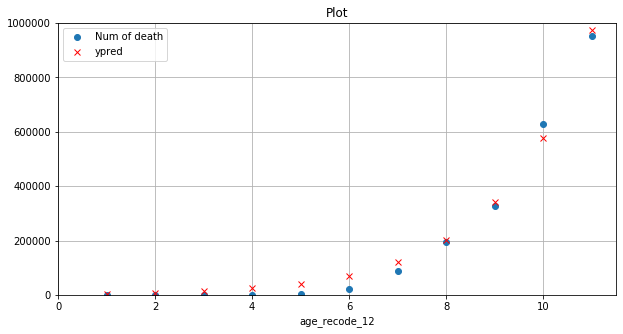

In [17]:
df_63_age_agg=df_63_age[['Num of death', 'ypred','age_recode_12']].groupby('age_recode_12').sum().reset_index()
df_63_age_agg.plot(x='age_recode_12', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'])
plt.xlim(0,11.5)
plt.ylim(0,1000000)
plt.title('Plot')
plt.show()

# Try 16 Use dummy variables for age

In [10]:
df_63_age_dum=pd.get_dummies(df_63_age['age_recode_12'], prefix='age')
df_63_age_dum=pd.concat([df_63_age, df_63_age_dum ], axis=1)

In [11]:
df_63_age_dum.head(12)

,age_recode_12,Num of death,age_1,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,age_10,age_11,age_12
0,1,62,1,0,0,0,0,0,0,0,0,0,0,0
1,2,37,0,1,0,0,0,0,0,0,0,0,0,0
2,3,78,0,0,1,0,0,0,0,0,0,0,0,0
3,4,612,0,0,0,1,0,0,0,0,0,0,0,0
4,5,4131,0,0,0,0,1,0,0,0,0,0,0,0
5,6,21875,0,0,0,0,0,1,0,0,0,0,0,0
6,7,86650,0,0,0,0,0,0,1,0,0,0,0,0
7,8,193481,0,0,0,0,0,0,0,1,0,0,0,0
8,9,325655,0,0,0,0,0,0,0,0,1,0,0,0
9,10,627655,0,0,0,0,0,0,0,0,0,1,0,0


In [20]:
df_63_age_dum = df_63_age_dum.drop('ypred', axis=1)

In [21]:
df_63_age_dum.columns

Index(['age_recode_12', 'Num of death', 'age_1', 'age_2', 'age_3', 'age_4',
       'age_5', 'age_6', 'age_7', 'age_8', 'age_9', 'age_10', 'age_11',
       'age_12'],
      dtype='object')

In [23]:
#df_63_age_dum.head(12)

In [24]:
#age_dummy={'age_1', 'age_2', 'age_3', 'age_4', 'age_5', 'age_6', 'age_7', 'age_8',
#       'age_9', 'age_10', 'age_11',  'age_12'}
age_dummy={'age_5', 'age_6', 'age_7', 'age_8', 'age_9', 'age_10', 'age_11'}

In [25]:
x=df_63_age_dum[age_dummy]
x_pd = sm.add_constant(x)
y=df_63_age_dum['Num of death']
glm_model = sm.GLM(y, x_pd, family=sm.families.Poisson(), freq_weights=y)
glm_model_results = glm_model.fit()
print(glm_model_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           Num of death   No. Observations:                   12
Model:                            GLM   Df Residuals:                  2212512
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.6725e+07
Date:                Wed, 27 Nov 2019   Deviance:                   1.6298e+05
Time:                        18:04:19   Pearson chi2:                 1.19e+05
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1101      0.002   3829.081      0.0

In [26]:
ypred = glm_model_results.predict(x_pd)
df_63_age_dum['ypred'] = pd.DataFrame(ypred)

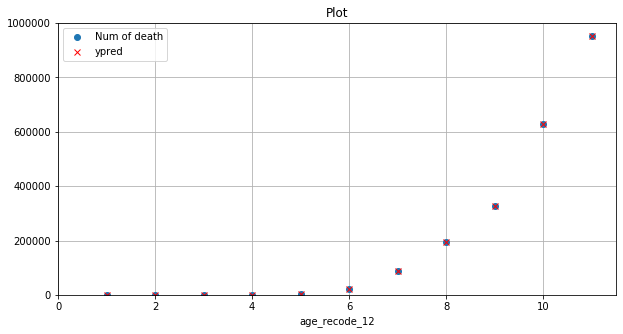

In [28]:
df_63_age_dum_agg=df_63_age_dum[['age_recode_12','Num of death', 'ypred']].groupby('age_recode_12').mean().reset_index()
df_63_age_dum_agg.plot(x='age_recode_12', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'])
plt.xlim(0,11.5)
plt.ylim(0,1000000)
plt.legend(loc='upper left')
plt.title('Plot')
plt.show()

# Try 17 Age and year with dummy variables for age

In [29]:
df_63_ay=df_63.groupby(['age_recode_12','current_data_year']).size().reset_index(name="Num of death")

In [30]:
df_63_ay_dum=pd.get_dummies(df_63_ay['age_recode_12'], prefix='age')
df_63_ay_dum=pd.concat([df_63_ay, df_63_ay_dum], axis=1)

In [31]:
df_63_ay_dum.head(12)

,age_recode_12,current_data_year,Num of death,age_1,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,age_10,age_11,age_12
0,1,2005,1,1,0,0,0,0,0,0,0,0,0,0,0
1,1,2006,9,1,0,0,0,0,0,0,0,0,0,0,0
2,1,2007,11,1,0,0,0,0,0,0,0,0,0,0,0
3,1,2008,5,1,0,0,0,0,0,0,0,0,0,0,0
4,1,2009,7,1,0,0,0,0,0,0,0,0,0,0,0
5,1,2010,4,1,0,0,0,0,0,0,0,0,0,0,0
6,1,2011,5,1,0,0,0,0,0,0,0,0,0,0,0
7,1,2012,7,1,0,0,0,0,0,0,0,0,0,0,0
8,1,2013,4,1,0,0,0,0,0,0,0,0,0,0,0
9,1,2014,6,1,0,0,0,0,0,0,0,0,0,0,0


In [32]:
df_63_ay_dum.columns

Index(['age_recode_12', 'current_data_year', 'Num of death', 'age_1', 'age_2',
       'age_3', 'age_4', 'age_5', 'age_6', 'age_7', 'age_8', 'age_9', 'age_10',
       'age_11', 'age_12'],
      dtype='object')

In [33]:
features ={'age_5', 'age_6', 'age_7', 'age_8', 'age_9', 'age_10', 'age_11', 'current_data_year'}

In [34]:
x=df_63_ay_dum[features]
x_pd = sm.add_constant(x)
y=df_63_ay_dum['Num of death']
glm_model = sm.GLM(y, x_pd, family=sm.families.Poisson(), freq_weights=y)
glm_model_results = glm_model.fit()
print(glm_model_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           Num of death   No. Observations:                  132
Model:                            GLM   Df Residuals:                  2212511
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.6410e+08
Date:                Wed, 27 Nov 2019   Deviance:                   3.0021e+08
Time:                        18:11:10   Pearson chi2:                 3.04e+08
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                43.0932      0.00

In [36]:
#df_63_ay_dum.isnull().any() : no null value

In [37]:
ypred = glm_model_results.predict(x_pd)
df_63_ay_dum['ypred'] = pd.DataFrame(ypred)

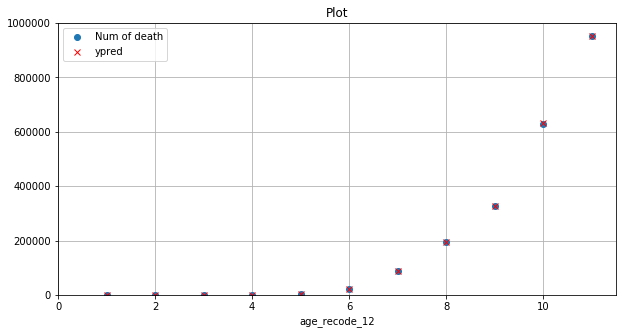

In [38]:
df_63_ay_dum_agg=df_63_ay_dum[['age_recode_12',  'current_data_year', 'Num of death', 'ypred']].groupby('age_recode_12').sum().reset_index()
df_63_ay_dum_agg.plot(x='age_recode_12', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'])
plt.xlim(0,11.5)
plt.ylim(0,1000000)
plt.legend(loc='upper left')
plt.title('Plot')
plt.show()

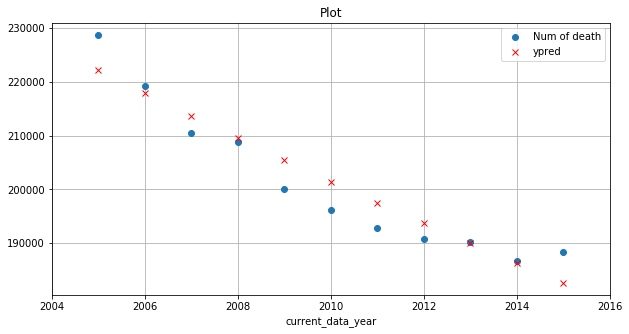

In [39]:
df_63_ay_dum_agg =df_63_ay_dum[['current_data_year', 'Num of death', 'ypred']].groupby('current_data_year').sum().reset_index()
df_63_ay_dum_agg.plot(x='current_data_year', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'])
plt.title('Plot')
plt.xlim(2004, 2016)
plt.show()

# Try 18 All our variables with dummy variables for age

In [40]:
df_63_all = df_63.groupby(['age_recode_12','current_data_year','education_2003_revision', 'injury_at_work', 'manner_of_death', 'marital_status', 'month_of_death', 'race_recode_5', 'sex']).size().reset_index(name="Num of death")

In [41]:
df_63_all_dum=pd.get_dummies(df_63_all['age_recode_12'], prefix='age')
df_63_all_dum=pd.concat([df_63_all, df_63_all_dum ], axis=1)

In [42]:
df_63_all_dum.head(15)

,age_recode_12,current_data_year,education_2003_revision,injury_at_work,manner_of_death,marital_status,month_of_death,race_recode_5,sex,Num of death,...,age_3,age_4,age_5,age_6,age_7,age_8,age_9,age_10,age_11,age_12
0,1,2006,1.0,U,7.0,S,9,1,M,1,...,0,0,0,0,0,0,0,0,0,0
1,1,2006,9.0,U,7.0,S,2,1,M,1,...,0,0,0,0,0,0,0,0,0,0
2,1,2006,9.0,U,7.0,S,8,2,M,1,...,0,0,0,0,0,0,0,0,0,0
3,1,2006,9.0,U,7.0,S,8,4,M,1,...,0,0,0,0,0,0,0,0,0,0
4,1,2006,9.0,U,7.0,S,11,2,F,1,...,0,0,0,0,0,0,0,0,0,0
5,1,2006,9.0,U,7.0,S,12,1,M,1,...,0,0,0,0,0,0,0,0,0,0
6,1,2007,1.0,U,7.0,S,3,1,F,1,...,0,0,0,0,0,0,0,0,0,0
7,1,2007,1.0,U,7.0,S,7,1,F,1,...,0,0,0,0,0,0,0,0,0,0
8,1,2007,1.0,U,7.0,S,9,4,F,1,...,0,0,0,0,0,0,0,0,0,0
9,1,2007,1.0,U,7.0,S,11,1,M,1,...,0,0,0,0,0,0,0,0,0,0


In [43]:
inj_dummies = pd.get_dummies(df_63_all['injury_at_work'],prefix='inj')
inj_dummies.columns

Index(['inj_N', 'inj_U', 'inj_Y'], dtype='object')

In [44]:
mar_dummies = pd.get_dummies(df_63_all['marital_status'],prefix='mar')
mar_dummies.columns

Index(['mar_D', 'mar_M', 'mar_S', 'mar_U', 'mar_W'], dtype='object')

In [45]:
sex_dummies = pd.get_dummies(df_63_all['sex'],prefix='sex')
sex_dummies.columns

Index(['sex_F', 'sex_M'], dtype='object')

In [46]:
df_63_all_dum = pd.concat([df_63_all_dum, inj_dummies, mar_dummies, sex_dummies], axis=1)

In [48]:
df_63_all_dum.head(15)

,age_recode_12,current_data_year,education_2003_revision,injury_at_work,manner_of_death,marital_status,month_of_death,race_recode_5,sex,Num of death,...,inj_N,inj_U,inj_Y,mar_D,mar_M,mar_S,mar_U,mar_W,sex_F,sex_M
0,1,2006,1.0,U,7.0,S,9,1,M,1,...,0,1,0,0,0,1,0,0,0,1
1,1,2006,9.0,U,7.0,S,2,1,M,1,...,0,1,0,0,0,1,0,0,0,1
2,1,2006,9.0,U,7.0,S,8,2,M,1,...,0,1,0,0,0,1,0,0,0,1
3,1,2006,9.0,U,7.0,S,8,4,M,1,...,0,1,0,0,0,1,0,0,0,1
4,1,2006,9.0,U,7.0,S,11,2,F,1,...,0,1,0,0,0,1,0,0,1,0
5,1,2006,9.0,U,7.0,S,12,1,M,1,...,0,1,0,0,0,1,0,0,0,1
6,1,2007,1.0,U,7.0,S,3,1,F,1,...,0,1,0,0,0,1,0,0,1,0
7,1,2007,1.0,U,7.0,S,7,1,F,1,...,0,1,0,0,0,1,0,0,1,0
8,1,2007,1.0,U,7.0,S,9,4,F,1,...,0,1,0,0,0,1,0,0,1,0
9,1,2007,1.0,U,7.0,S,11,1,M,1,...,0,1,0,0,0,1,0,0,0,1


In [49]:
df_63_all_dum.columns

Index(['age_recode_12', 'current_data_year', 'education_2003_revision',
       'injury_at_work', 'manner_of_death', 'marital_status', 'month_of_death',
       'race_recode_5', 'sex', 'Num of death', 'age_1', 'age_2', 'age_3',
       'age_4', 'age_5', 'age_6', 'age_7', 'age_8', 'age_9', 'age_10',
       'age_11', 'age_12', 'inj_N', 'inj_U', 'inj_Y', 'mar_D', 'mar_M',
       'mar_S', 'mar_U', 'mar_W', 'sex_F', 'sex_M'],
      dtype='object')

In [63]:
prm = {'age_recode_12', 'current_data_year', 'education_2003_revision',
       'injury_at_work', 'manner_of_death', 'marital_status', 'month_of_death',
       'race_recode_5', 'sex', 'Num of death', 'age_1', 'age_2', 'age_3',
       'age_4', 'age_5', 'age_6', 'age_7', 'age_8', 'age_9', 'age_10',
       'age_11', 'age_12', 'inj_N', 'inj_U', 'inj_Y', 'mar_D', 'mar_M',
       'mar_S', 'mar_U', 'mar_W', 'sex_F', 'sex_M', 'ypred'}

In [51]:
features={'age_5', 'age_6', 'age_7', 'age_8', 'age_9', 'age_10', 'age_11', 'current_data_year', 'education_2003_revision', 'manner_of_death', 'month_of_death', 'race_recode_5', 'inj_N', 'inj_U', 'inj_Y', 'mar_D', 'mar_M', 'mar_S', 'mar_U', 'mar_W', 'sex_F', 'sex_M' }

In [52]:
x=df_63_all_dum[features]
x_pd = sm.add_constant(x)
#x = sm.add_constant(x)
y=df_63_all_dum['Num of death']
glm_model = sm.GLM(y, x_pd, family=sm.families.Poisson())
glm_model_results = glm_model.fit()
print(glm_model_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           Num of death   No. Observations:               127669
Model:                            GLM   Df Residuals:                   127649
Model Family:                 Poisson   Df Model:                           19
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2166e+06
Date:                Wed, 27 Nov 2019   Deviance:                   2.0410e+06
Time:                        18:25:29   Pearson chi2:                 7.25e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [53]:
ypred = glm_model_results.predict(x_pd)
df_63_all_dum['ypred'] = pd.DataFrame(ypred)

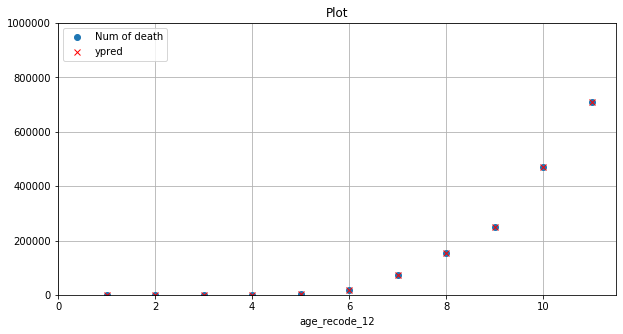

In [66]:
df_63_all_dum_agg=df_63_all_dum[['age_recode_12', 'Num of death', 'ypred']].groupby('age_recode_12').sum().reset_index()
#df_63_all_dum_agg=df_63_all_dum[prm].groupby('age_recode_12').sum().reset_index()
df_63_all_dum_agg.plot(x='age_recode_12', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'])
plt.xlim(0,11.5)
plt.ylim(0,1000000)
plt.legend(loc='upper left')
plt.title('Plot')
plt.show()

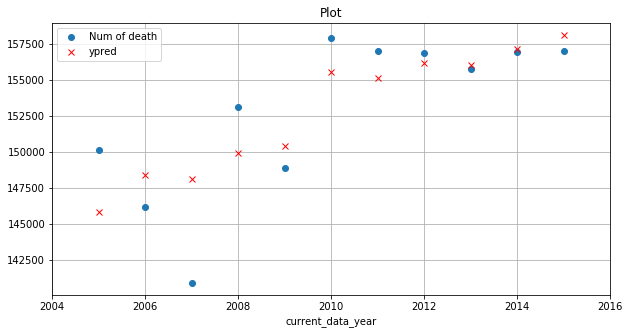

In [67]:
df_63_all_dum_agg =df_63_all_dum[['current_data_year', 'Num of death', 'ypred']].groupby('current_data_year').sum().reset_index()
df_63_all_dum_agg.plot(x='current_data_year', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'])
plt.title('Plot')
plt.xlim(2004, 2016)
plt.show()

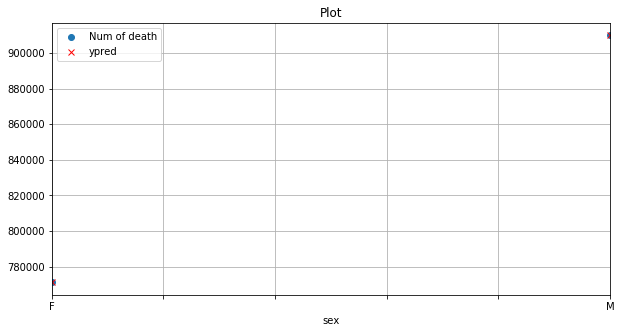

In [68]:
df_63_all_dum_agg =df_63_all_dum[['sex', 'Num of death', 'ypred']].groupby('sex').sum().reset_index()
df_63_all_dum_agg.plot(x='sex', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'])
plt.title('Plot')
plt.show()

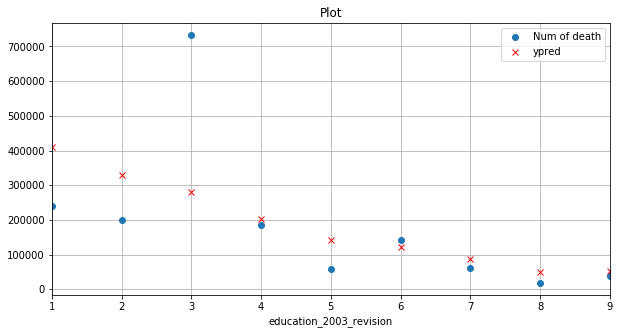

In [69]:
df_63_all_dum_agg =df_63_all_dum[['education_2003_revision', 'Num of death', 'ypred']].groupby('education_2003_revision').sum().reset_index()
df_63_all_dum_agg.plot(x='education_2003_revision', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'])
plt.title('Plot')
plt.show()

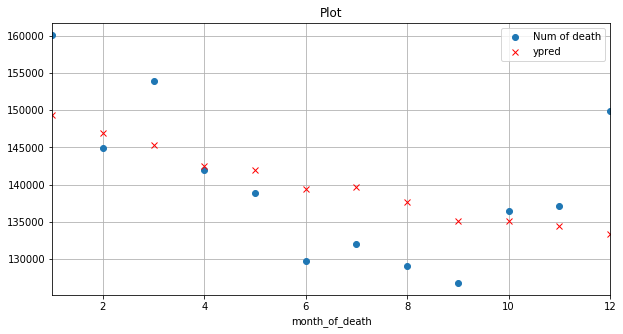

In [70]:
df_63_all_dum_agg =df_63_all_dum[['month_of_death', 'Num of death', 'ypred']].groupby('month_of_death').sum().reset_index()
df_63_all_dum_agg.plot(x='month_of_death', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'])
plt.title('Plot')
plt.show()

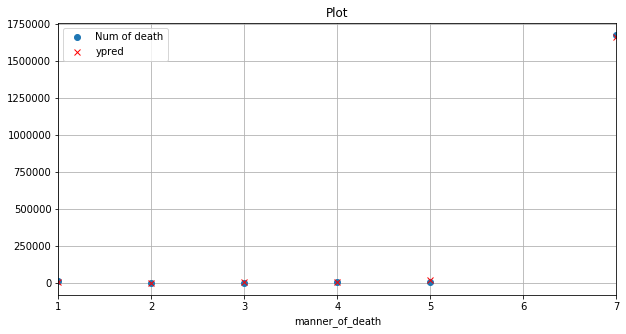

In [71]:
df_63_all_dum_agg =df_63_all_dum[['manner_of_death', 'Num of death', 'ypred']].groupby('manner_of_death').sum().reset_index()
df_63_all_dum_agg.plot(x='manner_of_death', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'])
plt.title('Plot')
plt.show()

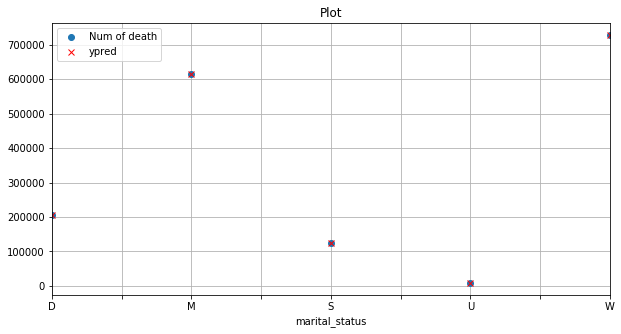

In [72]:
df_63_all_dum_agg =df_63_all_dum[['marital_status', 'Num of death', 'ypred']].groupby('marital_status').sum().reset_index()
df_63_all_dum_agg.plot(x='marital_status', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'])
plt.title('Plot')
plt.show()

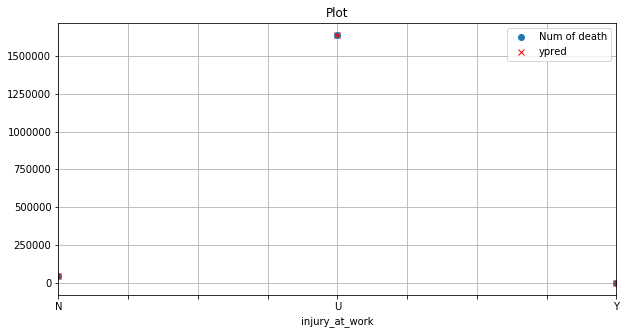

In [73]:
df_63_all_dum_agg =df_63_all_dum[['injury_at_work', 'Num of death', 'ypred']].groupby('injury_at_work').sum().reset_index()
df_63_all_dum_agg.plot(x='injury_at_work', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'])
plt.title('Plot')
plt.show()

# rtry 1

In [33]:
df_63_rt1 = df_63.groupby(['age_recode_12','current_data_year','education_2003_revision', 'marital_status', 'month_of_death', 'race_recode_5', 'sex']).size().reset_index(name="Num of death")

In [34]:
df_63_rt1_dum=pd.get_dummies(df_63_rt1['age_recode_12'], prefix='age')
df_63_rt1_dum=pd.concat([df_63_rt1, df_63_rt1_dum ], axis=1)

In [35]:
mar_dummies = pd.get_dummies(df_63_rt1['marital_status'],prefix='mar')
mar_dummies.columns

Index(['mar_D', 'mar_M', 'mar_S', 'mar_U', 'mar_W'], dtype='object')

In [36]:
sex_dummies = pd.get_dummies(df_63_rt1['sex'],prefix='sex')
sex_dummies.columns

Index(['sex_F', 'sex_M'], dtype='object')

In [37]:
edu_dummies = pd.get_dummies(df_63_rt1['education_2003_revision'],prefix='edu')
edu_dummies.columns

Index(['edu_1.0', 'edu_2.0', 'edu_3.0', 'edu_4.0', 'edu_5.0', 'edu_6.0',
       'edu_7.0', 'edu_8.0', 'edu_9.0'],
      dtype='object')

In [40]:
df_63_rt1_dum = pd.concat([df_63_rt1_dum, mar_dummies, sex_dummies,edu_dummies], axis=1)

In [41]:
df_63_rt1_dum.columns

Index(['age_recode_12', 'current_data_year', 'education_2003_revision',
       'marital_status', 'month_of_death', 'race_recode_5', 'sex',
       'Num of death', 'age_1', 'age_2', 'age_3', 'age_4', 'age_5', 'age_6',
       'age_7', 'age_8', 'age_9', 'age_10', 'age_11', 'age_12', 'mar_D',
       'mar_M', 'mar_S', 'mar_U', 'mar_W', 'sex_F', 'sex_M', 'mar_D', 'mar_M',
       'mar_S', 'mar_U', 'mar_W', 'sex_F', 'sex_M', 'edu_1.0', 'edu_2.0',
       'edu_3.0', 'edu_4.0', 'edu_5.0', 'edu_6.0', 'edu_7.0', 'edu_8.0',
       'edu_9.0'],
      dtype='object')

In [42]:
features={'age_5', 'age_6', 'age_7', 'age_8', 'age_9', 'age_10', 'age_11', 'current_data_year', 'edu_1.0', 'edu_3.0', 'edu_4.0', 'month_of_death', 'race_recode_5', 'mar_D', 'mar_M', 'mar_S', 'mar_U', 'mar_W', 'sex_F', 'sex_M' }

In [43]:
x=df_63_rt1_dum[features]
x_pd = sm.add_constant(x)
#x = sm.add_constant(x)
y=df_63_rt1_dum['Num of death']
glm_model = sm.GLM(y, x_pd, family=sm.families.Poisson())
glm_model_results = glm_model.fit()
print(glm_model_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           Num of death   No. Observations:               113827
Model:                            GLM   Df Residuals:                   113808
Model Family:                 Poisson   Df Model:                           18
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1029e+06
Date:                Sat, 30 Nov 2019   Deviance:                   1.8177e+06
Time:                        21:46:09   Pearson chi2:                 2.98e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                17.2145      0.17

In [44]:
ypred = glm_model_results.predict(x_pd)
df_63_rt1_dum['ypred'] = pd.DataFrame(ypred)

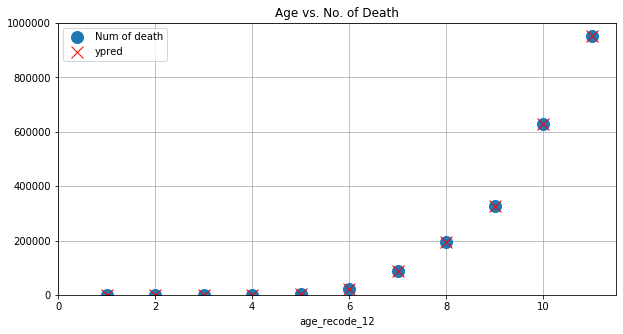

In [51]:
df_63_rt1_dum_agg=df_63_rt1_dum.groupby('age_recode_12').sum().reset_index()
df_63_rt1_dum_agg.plot(x='age_recode_12', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'], markersize=12)
plt.xlim(0,11.5)
plt.ylim(0,1000000)
plt.legend(loc='upper left')
plt.title('Age vs. No. of Death')
plt.show()

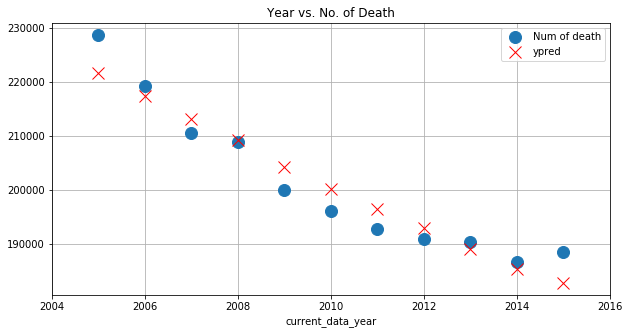

In [52]:
df_63_rt1_dum_agg =df_63_rt1_dum.groupby('current_data_year').sum().reset_index()
df_63_rt1_dum_agg.plot(x='current_data_year', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'],markersize=12)
plt.title('Year vs. No. of Death')
plt.xlim(2004, 2016)
plt.show()

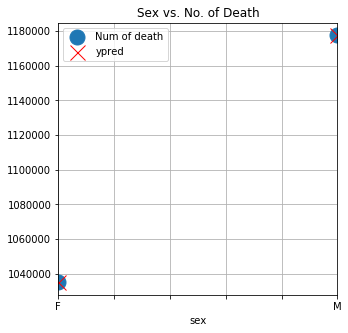

In [58]:
df_63_rt1_dum_agg =df_63_rt1_dum.groupby('sex').sum().reset_index()
df_63_rt1_dum_agg.plot(x='sex', y=['Num of death', 'ypred'], figsize=(5,5), grid=True, style=['o','rx'], markersize=15)
plt.title('Sex vs. No. of Death')
plt.show()

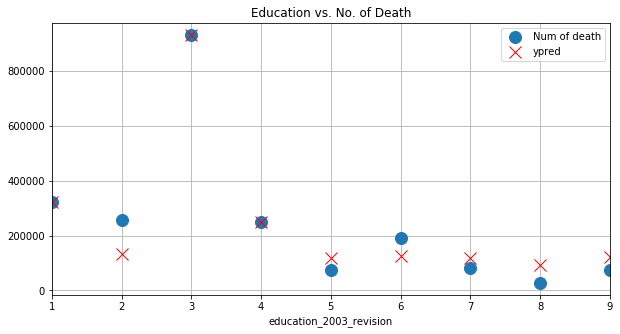

In [57]:
df_63_rt1_dum_agg =df_63_rt1_dum.groupby('education_2003_revision').sum().reset_index()
df_63_rt1_dum_agg.plot(x='education_2003_revision', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'], markersize=12)
plt.title('Education vs. No. of Death')
plt.show()

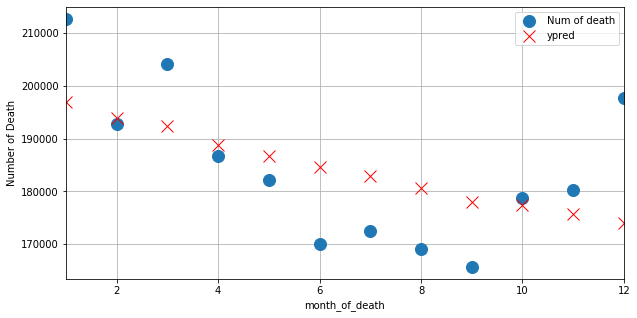

In [61]:
df_63_rt1_dum_agg =df_63_rt1_dum.groupby('month_of_death').sum().reset_index()
df_63_rt1_dum_agg.plot(x='month_of_death', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'], markersize=12)
plt.ylabel("Number of Death")
plt.show()

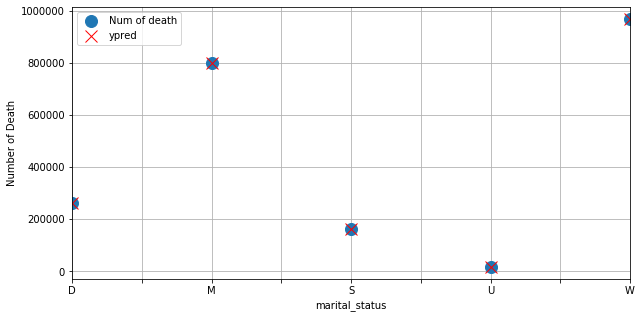

In [62]:
df_63_rt1_dum_agg =df_63_rt1_dum[['marital_status', 'Num of death', 'ypred']].groupby('marital_status').sum().reset_index()
df_63_rt1_dum_agg.plot(x='marital_status', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'], markersize=12)
plt.ylabel("Number of Death")
plt.show()

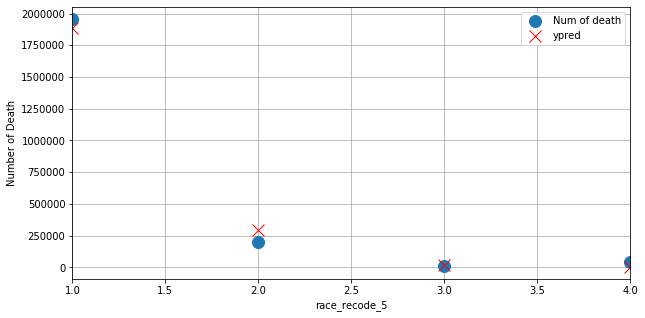

In [63]:
df_63_rt1_dum_agg =df_63_rt1_dum.groupby('race_recode_5').sum().reset_index()
df_63_rt1_dum_agg.plot(x='race_recode_5', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'], markersize=12)
plt.ylabel("Number of Death")
plt.show()

# rtry 2 (month of death include 2-order polynomial)

In [10]:
df_63_rt2 = df_63.groupby(['age_recode_12','current_data_year','education_2003_revision', 'marital_status', 'month_of_death', 'sex']).size().reset_index(name="Num of death")

In [11]:
df_63_rt2_dum=pd.get_dummies(df_63_rt2['age_recode_12'], prefix='age')
df_63_rt2_dum=pd.concat([df_63_rt2, df_63_rt2_dum], axis=1)

In [12]:
df_63_rt2_dum.columns

Index(['age_recode_12', 'current_data_year', 'education_2003_revision',
       'marital_status', 'month_of_death', 'sex', 'Num of death', 'age_1',
       'age_2', 'age_3', 'age_4', 'age_5', 'age_6', 'age_7', 'age_8', 'age_9',
       'age_10', 'age_11', 'age_12'],
      dtype='object')

In [13]:
mar_dummies = pd.get_dummies(df_63_rt2['marital_status'],prefix='mar')
mar_dummies.columns

Index(['mar_D', 'mar_M', 'mar_S', 'mar_U', 'mar_W'], dtype='object')

In [14]:
sex_dummies = pd.get_dummies(df_63_rt2['sex'],prefix='sex')
sex_dummies.columns

Index(['sex_F', 'sex_M'], dtype='object')

In [15]:
edu_dummies = pd.get_dummies(df_63_rt2['education_2003_revision'],prefix='edu')
edu_dummies.columns

Index(['edu_1.0', 'edu_2.0', 'edu_3.0', 'edu_4.0', 'edu_5.0', 'edu_6.0',
       'edu_7.0', 'edu_8.0', 'edu_9.0'],
      dtype='object')

In [16]:
df_63_rt2_dum = pd.concat([df_63_rt2_dum, mar_dummies, sex_dummies, edu_dummies], axis=1)

In [17]:
df_63_rt2_dum['month_of_death_sq'] = np.power(df_63_rt2_dum['month_of_death'], 2)

In [20]:
features={'age_5', 'age_6', 'age_7', 'age_8', 'age_9', 'age_10', 'age_11', 'current_data_year', 'edu_1.0', 'edu_3.0', 'edu_4.0', 'month_of_death', 'month_of_death_sq', 'mar_D', 'mar_M', 'mar_S', 'mar_U', 'mar_W', 'sex_F', 'sex_M' }

In [21]:
x=df_63_rt2_dum[features]
x_pd = sm.add_constant(x)
#x = sm.add_constant(x)
y=df_63_rt2_dum['Num of death']
glm_model = sm.GLM(y, x_pd, family=sm.families.Poisson())
glm_model_results = glm_model.fit()
print(glm_model_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           Num of death   No. Observations:                55799
Model:                            GLM   Df Residuals:                    55780
Model Family:                 Poisson   Df Model:                           18
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.1188e+05
Date:                Mon, 02 Dec 2019   Deviance:                   1.5898e+06
Time:                        17:07:11   Pearson chi2:                 2.13e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                22.9513      0.25

In [22]:
ypred = glm_model_results.predict(x_pd)
df_63_rt2_dum['ypred'] = pd.DataFrame(ypred)

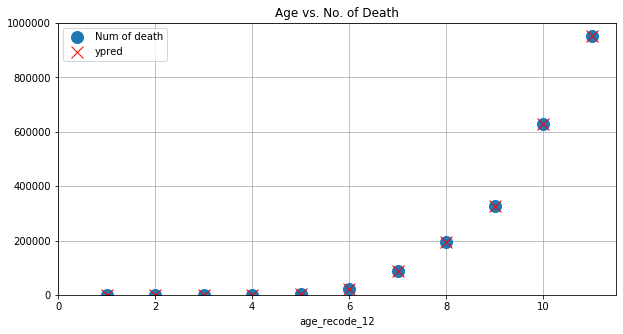

In [23]:
df_63_rt2_dum_agg=df_63_rt2_dum.groupby('age_recode_12').sum().reset_index()
df_63_rt2_dum_agg.plot(x='age_recode_12', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'], markersize=12)
plt.xlim(0,11.5)
plt.ylim(0,1000000)
plt.legend(loc='upper left')
plt.title('Age vs. No. of Death')
plt.show()

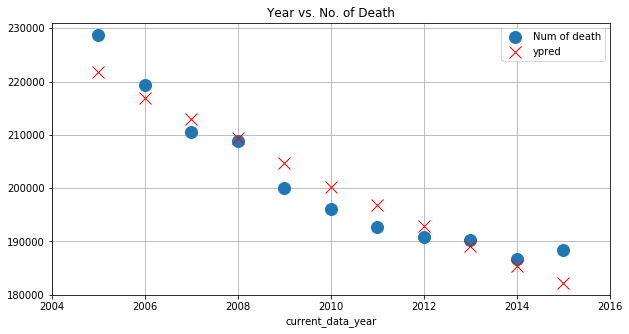

In [24]:
df_63_rt2_dum_agg =df_63_rt2_dum.groupby('current_data_year').sum().reset_index()
df_63_rt2_dum_agg.plot(x='current_data_year', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'],markersize=12)
plt.title('Year vs. No. of Death')
plt.xlim(2004, 2016)
plt.show()

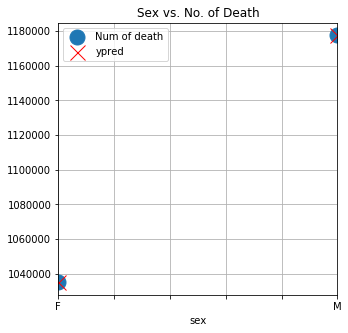

In [25]:
df_63_rt2_dum_agg =df_63_rt2_dum.groupby('sex').sum().reset_index()
df_63_rt2_dum_agg.plot(x='sex', y=['Num of death', 'ypred'], figsize=(5,5), grid=True, style=['o','rx'], markersize=15)
plt.title('Sex vs. No. of Death')
plt.show()

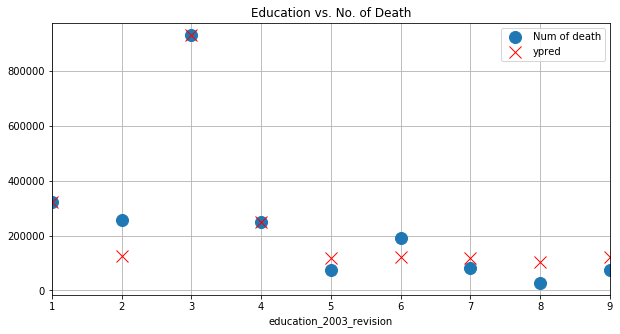

In [26]:
df_63_rt2_dum_agg =df_63_rt2_dum.groupby('education_2003_revision').sum().reset_index()
df_63_rt2_dum_agg.plot(x='education_2003_revision', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'], markersize=12)
plt.title('Education vs. No. of Death')
plt.show()

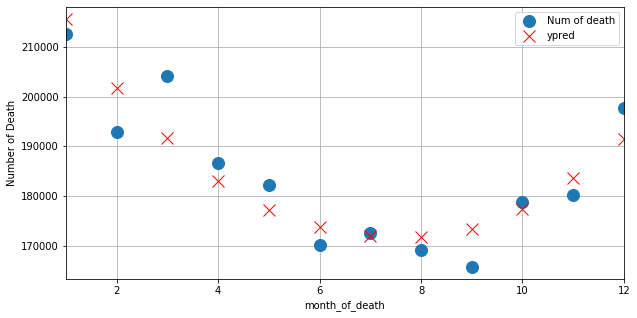

In [27]:
df_63_rt2_dum_agg =df_63_rt2_dum.groupby('month_of_death').sum().reset_index()
df_63_rt2_dum_agg.plot(x='month_of_death', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'], markersize=12)
plt.ylabel("Number of Death")
plt.show()

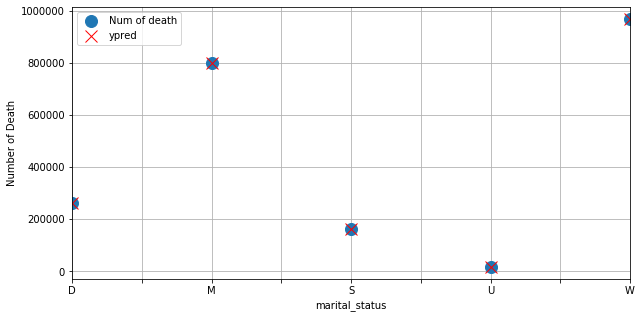

In [28]:
df_63_rt2_dum_agg =df_63_rt2_dum[['marital_status', 'Num of death', 'ypred']].groupby('marital_status').sum().reset_index()
df_63_rt2_dum_agg.plot(x='marital_status', y=['Num of death', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'], markersize=12)
plt.ylabel("Number of Death")
plt.show()